In [1]:
import numpy as np
import  matplotlib.pyplot as plt
from matplotlib import ticker
from python_files.maxent import MaxEnt
import python_files.densities as d

In [2]:
#Set sizes 
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def plot_solution_performance_test(title, outside_interval,
                                   Ns, error_lambda, MAXERR,
                                   horizontal,
                                   save_as=None,
                                   nbins=6):
    to_delete_indices = np.where(error_lambda.flatten() == MAXERR)[0]
    error_lambda_flat = np.delete(error_lambda.flatten(), to_delete_indices)
    outside_interval_flat = np.delete(outside_interval.flatten(), to_delete_indices)
    Ns_flat = np.delete(Ns.flatten(), to_delete_indices)

    if(horizontal):
        fig, ax = plt.subplots(1, 2, sharey=False, sharex=True, figsize=(8,4))
        for i in range(2):
            ax[i].set_xlabel("Fraction of prob. mass outside $S$")

    else:
        fig, ax = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(4,8))
        ax[1].set_xlabel("Fraction of prob. mass outside $S$")
    
    fig.suptitle(f"Performance of Algorithm 2 on {title}")
    ax[0].set_ylabel("Quadrature number $n$")
    ax[1].set_ylabel("$\\lambda_{\\text{err}}$")

    for i in range(2):
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")

    #Fig 0: contour plot of quality converging values
    ax[0].set_title(f"Contour plot of quality")

    max_conv_error = np.max(error_lambda_flat)
    levels = np.linspace(0, max_conv_error, 25)
    cset1 = ax[0].contourf(outside_interval, Ns, error_lambda, 
                           levels=levels)
    
    cbar1 = fig.colorbar(cset1, ax=ax[0], format='%.2f')
    cbar1.set_label("$\\lambda_{\\text{err}}$", rotation=270)
    cbar1.locator = ticker.MaxNLocator(nbins=nbins)
    cbar1.update_ticks()


    #Fig 1: lambda_err as function of left-out prob mass
    ax[1].set_title("Quality vs. support")
    cset2 = ax[1].scatter(outside_interval_flat, error_lambda_flat, 
                          c=Ns_flat, norm="log")

    cbar2 = fig.colorbar(cset2, ax=ax[1])
    cbar2.set_label("$n$", rotation=270)

    plt.tight_layout()
    if(save_as is not None):
        plt.savefig(save_as)
    plt.show()

def test_performance_algo(title,
                          b_constraint,
                          f_constraint,
                          f_param,
                          lambda_actual,
                          cdf,
                          u_range,
                          lower_bound=None,
                          horizontal=False,
                          save_as=None,
                          nbins=6):
    
    #define parameters
    N_n = 20
    N_u = 50
    MAXERR = 1000
    
    arr_n = np.logspace(1, 2.5, N_n, dtype=int)
    arr_u = np.linspace(*u_range, N_u)

    #do simulations
    Us, Ns = np.meshgrid(arr_u,arr_n)

    error_lambda = np.full((N_n,N_u), MAXERR, dtype=float)
    outside_interval = np.zeros((N_n,N_u), dtype=float)

    for i in range(N_n):
        n = arr_n[i]
        for j in range(N_u):
            u = arr_u[j]
            if(lower_bound==None):
                l = -u
            else:
                l = lower_bound
            outside_interval[i][j] = 1 - cdf(u,*f_param) + cdf(l,*f_param)

            ob = MaxEnt(support=[l,u],
                               n_quadrature=n,
                               b_constraints=b_constraint(*f_param),
                               f_vector=f_constraint,
                               f_param=f_param,
                               warning_convergence=False)
            if(ob._converges):
                error_lambda[i][j] = ob.calc_error(lambda_actual(*f_param))

    #plot solution
    plot_solution_performance_test(title,
                                   outside_interval,
                                   Ns, 
                                   error_lambda, 
                                   MAXERR=MAXERR,
                                   horizontal=horizontal,
                                   save_as=save_as,
                                   nbins=nbins)


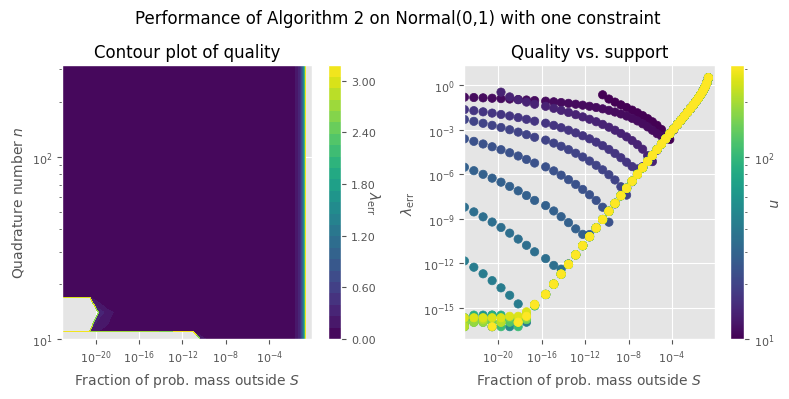

In [31]:
#normal 1 constraint
mu, s2 = 0, 1
test_performance_algo(title=f"Normal({mu},{s2}) with one constraint",
                    b_constraint=d.b_constraint_normal1,
                    f_constraint=d.f_constraint_normal1,
                    f_param=(mu,s2),
                    lambda_actual=d.lambda_actual_normal1,
                    cdf=d.cdf_norm, u_range=(.2,10),
                    horizontal=True,
                    save_as="figs/performance_normal1.pdf"
                    )

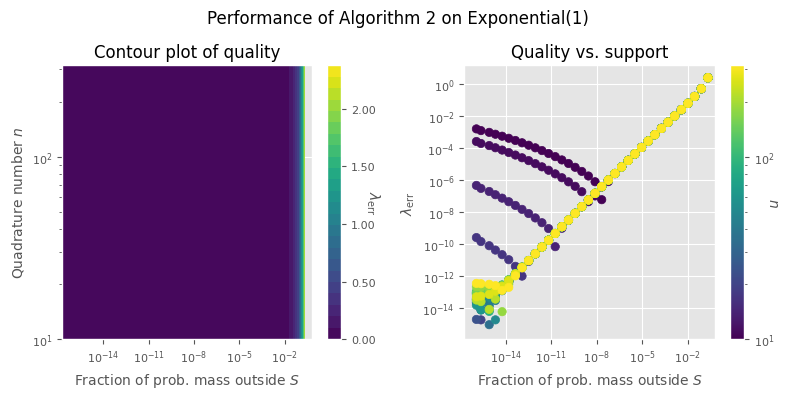

In [14]:
#Exponential
c = 1
test_performance_algo(title=f"Exponential({c})",
                    b_constraint=d.b_constraint_expon,
                    f_constraint=d.f_constraint_expon,
                    f_param=[c],
                    lambda_actual=d.lambda_actual_expon,
                    cdf=d.cdf_expon, u_range=(.5,50),
                    horizontal=True,
                    lower_bound=0,
                    save_as="figs/performance_exp.pdf",
                    nbins=5)

/home/liselotp/BRP/max_entropy/python_files/maxent.py:363: RuntimeWarning: overflow encountered in exp
  c, s = quad(lambda x: np.exp(np.inner(self._la,


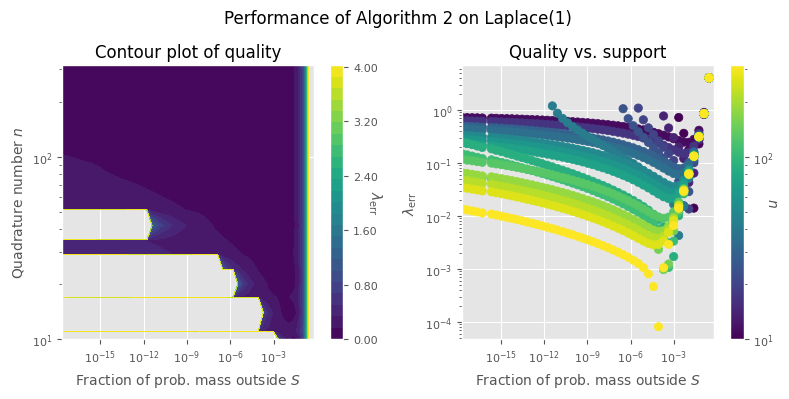

In [13]:
#Laplace
mu, c = 0, 1
test_performance_algo(title=f"Laplace({c})",
                    b_constraint=d.b_constraint_laplace,
                    f_constraint=d.f_constraint_laplace,
                    f_param=(mu,c),
                    lambda_actual=d.lambda_actual_laplace,
                    cdf=d.cdf_laplace, u_range=(.5,40),
                    horizontal=True,
                    save_as="figs/performance_laplace.pdf",
                    nbins=6)

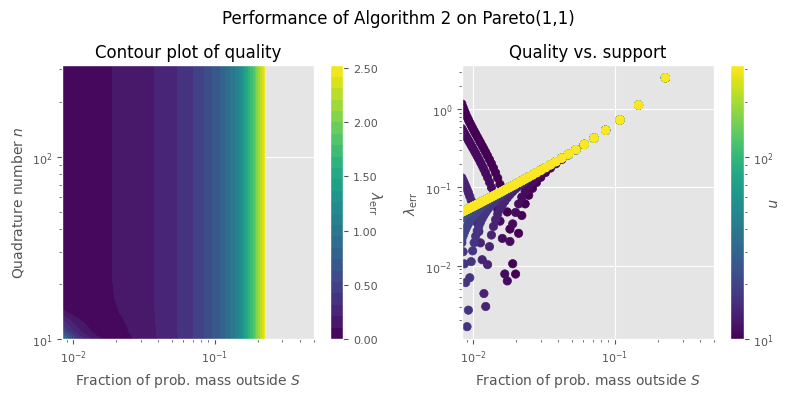

In [17]:
#Pareto
a, xm = 1, 1
test_performance_algo(title=f"Pareto({a},{xm})",
                    b_constraint=d.b_constraint_pareto,
                    f_constraint=d.f_constraint_pareto,
                    f_param=(a,xm),
                    lambda_actual=d.lambda_actual_pareto,
                    cdf=d.cdf_pareto, u_range=(2,120),
                    lower_bound=xm, horizontal=True,
                    save_as="figs/performance_pareto.pdf")

/home/liselotp/BRP/max_entropy/python_files/maxent.py:363: RuntimeWarning: overflow encountered in exp
  c, s = quad(lambda x: np.exp(np.inner(self._la,


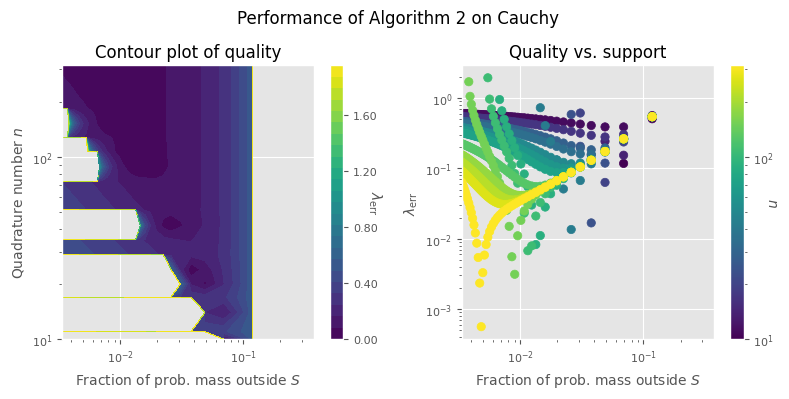

In [22]:
#Cauchy
test_performance_algo(title=f"Cauchy",
                    b_constraint=d.b_constraint_cauchy,
                    f_constraint=d.f_constraint_cauchy,
                    f_param=(),
                    lambda_actual=d.lambda_actual_cauchy,
                    cdf=d.cdf_cauchy, u_range=(1.5,190),
                    horizontal=True, 
                    save_as="figs/performance_cauchy.pdf")

/home/liselotp/BRP/max_entropy/python_files/maxent.py:363: RuntimeWarning: overflow encountered in exp
  c, s = quad(lambda x: np.exp(np.inner(self._la,


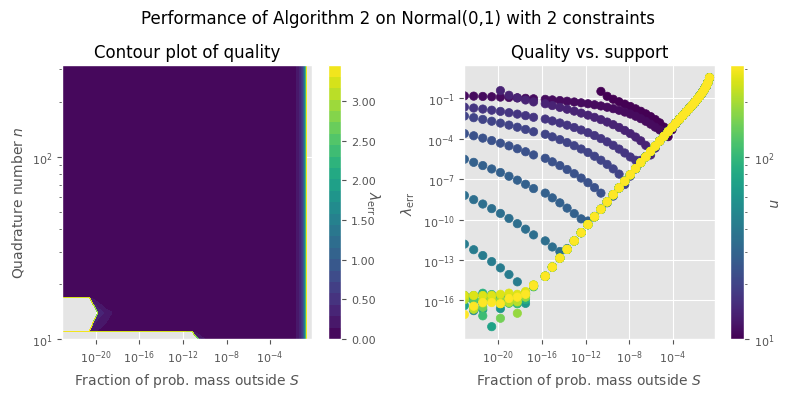

In [34]:
#normal 2
mu, s2 = 0, 1
test_performance_algo(title=f"Normal({mu},{s2}) with 2 constraints",
                    b_constraint=d.b_constraint_normal2,
                    f_constraint=d.f_constraint_normal2,
                    f_param=(mu,s2),
                    lambda_actual=d.lambda_actual_normal2,
                    cdf=d.cdf_norm,
                    u_range=(.4,10),
                    horizontal=True,
                    save_as="figs/performance_normal2.pdf",
                    nbins=7)

/home/liselotp/BRP/ME/lib/python3.12/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/home/liselotp/BRP/max_entropy/python_files/maxent.py:363: RuntimeWarning: overflow encountered in exp
  c, s = quad(lambda x: np.exp(np.inner(self._la,
/home/liselotp/BRP/max_entropy/python_files/maxent.py:363: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  c, s = quad(lambda x: np.exp(np.inner(self._la,
/home/liselotp/BRP/max_entropy/python_files/maxent.py:363: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  c, s = quad(lambda x: np.exp(np.inner(self._la,
/home/liselotp/BRP/max_entropy/python_files/maxent.py:363: IntegrationWarning: The maximum number of subdivisions (50) has been ac

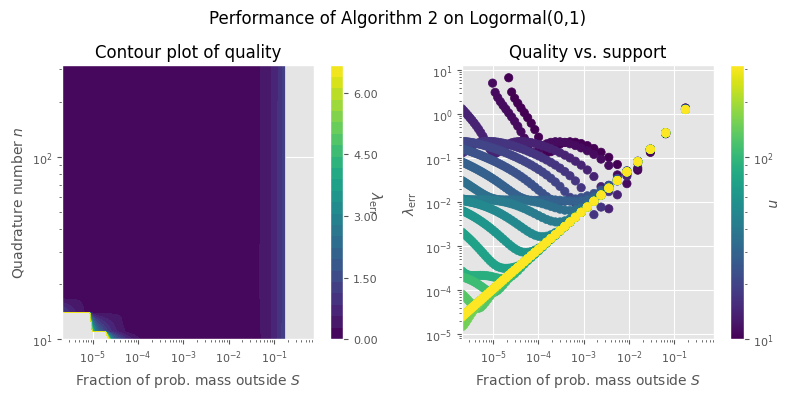

In [35]:
#Lognormal
mu, s2 = 0, 1
test_performance_algo(title=f"Logormal({mu},{s2})",
                    b_constraint=d.b_constraint_lognormal,
                    f_constraint=d.f_constraint_lognormal,
                    f_param=(mu,s2),
                    lambda_actual=d.lambda_actual_lognormal,
                    cdf=d.cdf_lognorm,
                    u_range=(.5,100),
                    lower_bound=0,
                    horizontal=True, 
                    save_as="figs/performance_lognormal.pdf",nbins=5)

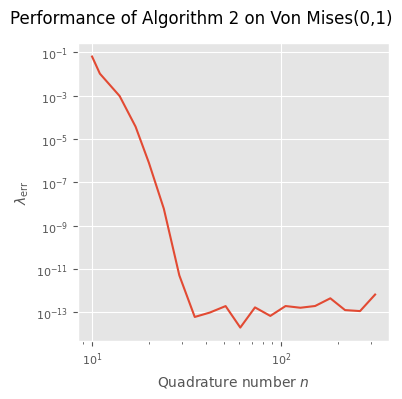

In [ ]:
#Von mises
mu, k = 0, 1
l, u = (0, 2*np.pi)
f_param=(l,u)


#define parameters
N_n = 20
MAXERR = 1000

arr_n = np.logspace(1, 2.5, N_n, dtype=int)

error_lambda = np.full((N_n), MAXERR, dtype=float)

for i in range(N_n):
    n = arr_n[i]

    ob = MaxEnt(support=[l,u],
                        n_quadrature=n,
                        b_constraints=d.b_constraint_vonmises(*f_param),
                        f_vector=d.f_constraint_vonmises,
                        f_param=f_param,
                        warning_convergence=False)
    if(ob._converges):
        error_lambda[i] = ob.calc_error(d.lambda_actual_vonmises(*f_param))



to_delete_indices = np.where(error_lambda == MAXERR)[0]
error_lambda_conv = np.delete(error_lambda, to_delete_indices)
Ns_conv = np.delete(arr_n, to_delete_indices)

fig, ax = plt.subplots(1, 1, sharey=False, sharex=True, figsize=(4,4))


fig.suptitle(f"Performance of Algorithm 2 on Von Mises({mu},{k})")
ax.set_ylabel("$\\lambda_{\\text{err}}$")
ax.set_xlabel("Quadrature number $n$")

ax.set_xscale("log")
ax.set_yscale("log")

ax.plot(arr_n, error_lambda)

plt.tight_layout()
plt.savefig("figs/performance_von_mises.pdf")
plt.show()

/home/liselotp/BRP/ME/lib/python3.12/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/home/liselotp/BRP/max_entropy/python_files/maxent.py:363: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  c, s = quad(lambda x: np.exp(np.inner(self._la,
/home/liselotp/BRP/max_entropy/python_files/maxent.py:363: RuntimeWarning: overflow encountered in exp
  c, s = quad(lambda x: np.exp(np.inner(self._la,


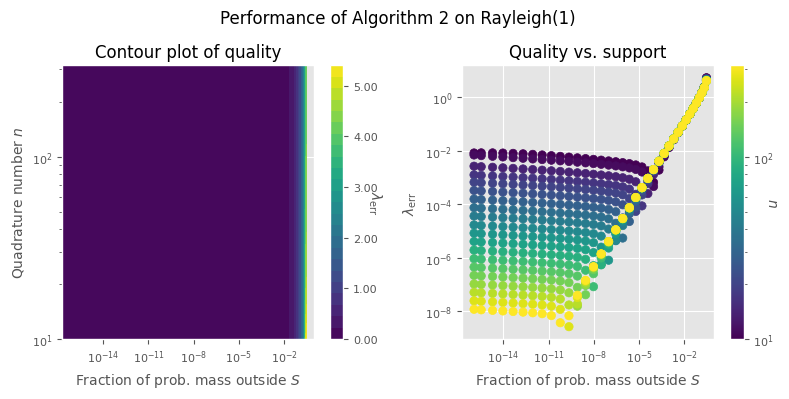

In [36]:
#Rayleigh
s2 = 1
test_performance_algo(title=f"Rayleigh({s2})",
                    b_constraint=d.b_constraint_rayleigh,
                    f_constraint=d.f_constraint_rayleigh,
                    f_param=[s2],
                    lambda_actual=d.lambda_actual_rayleigh,
                    cdf=d.cdf_rayleigh, u_range=(.4,10),
                    horizontal=True, 
                    lower_bound=0,
                    save_as="figs/performance_rayleigh.pdf")

/home/liselotp/BRP/ME/lib/python3.12/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/home/liselotp/BRP/max_entropy/python_files/maxent.py:363: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  c, s = quad(lambda x: np.exp(np.inner(self._la,


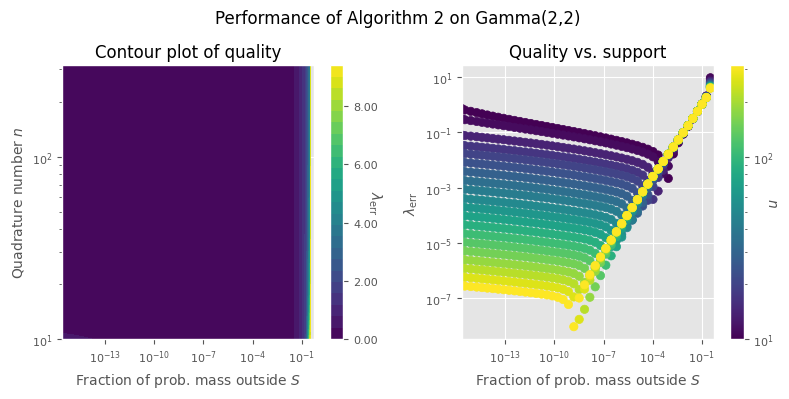

In [8]:
#Gamma
k, theta = 2, 2
test_performance_algo(title=f"Gamma({k},{theta})",
                    b_constraint=d.b_constraint_gamma,
                    f_constraint=d.f_constraint_gamma,
                    f_param=[k,theta],
                    lambda_actual=d.lambda_actual_gamma,
                    cdf=d.cdf_gamma, u_range=(3,80),
                    horizontal=True, 
                    lower_bound=0,
                    save_as="figs/performance_gamma.pdf")